<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Размер-выборки-и-изучение-общей-информации" data-toc-modified-id="Размер-выборки-и-изучение-общей-информации-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Размер выборки и изучение общей информации</a></span></li><li><span><a href="#График-распределения-возраста-в-выборке" data-toc-modified-id="График-распределения-возраста-в-выборке-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>График распределения возраста в выборке</a></span></li><li><span><a href="#Печать-на-экране-10–15-фотографий" data-toc-modified-id="Печать-на-экране-10–15-фотографий-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Печать на экране 10–15 фотографий</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей по фотографии

**Описание проекта**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**План работы**

1. Исследовательский анализ набора фотографий
2. Подготовка данных к обучению
3. Обучение нейронной сети, расчет её качества и выводы

## Исследовательский анализ данных

### Размер выборки и изучение общей информации

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

Загрузим CSV-файл с метками:

In [2]:
# чтение файла с метками
labels = pd.read_csv('/datasets/faces/labels.csv')

Изучим информацию о данных с метками:

In [3]:
#выводим первые 5 строк таблицы
display(labels.head())
    
#выводим информацию о данных
display(labels.info())
    
#выводим описательные статистики данных
display(labels.describe(include='all'))
    
#проверяем наличие явных дубликатов 
print('Количество дубликатов в объектах:', labels.duplicated().sum())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,006256.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


Количество дубликатов в объектах: 0


Размер выборки равен 7591 объектов, в ней содержится два признака - название файла и возраст человека. Пропусков и явных дубликатов в данных нет. Средний возраст людей на фотографии составляет 31 год, минимальный - 1 год, максимальный - 100 лет.

### График распределения возраста в выборке

Построим гистограмму распределения возраста в выборке. Так как возраст варьируется от 1 года до 100 лет, установим количество корзин (`bins`), равное 100. 

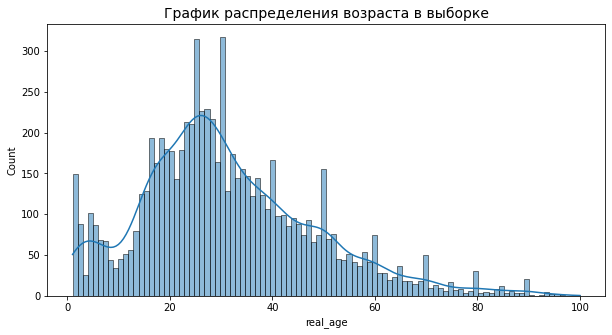

In [4]:
# график распределения возраста в выборке
plt.figure(figsize=(10,5))
sns.histplot(data=labels, x='real_age', bins=100, kde=True)
plt.title('График распределения возраста в выборке', fontsize=14)
plt.show()

Распределение возраста близко к нормальному, есть небольшой хвост справа. Медианный возраст в районе 29 лет. Видны пики гистограммы в районе некоторых круглых значений (40, 50, 60 и тд. лет), вероятно, когда точный возраст был неизвестен, его округляли.

### Печать на экране 10–15 фотографий

Выведем на экран 16 изображений:

Found 7591 validated image filenames.


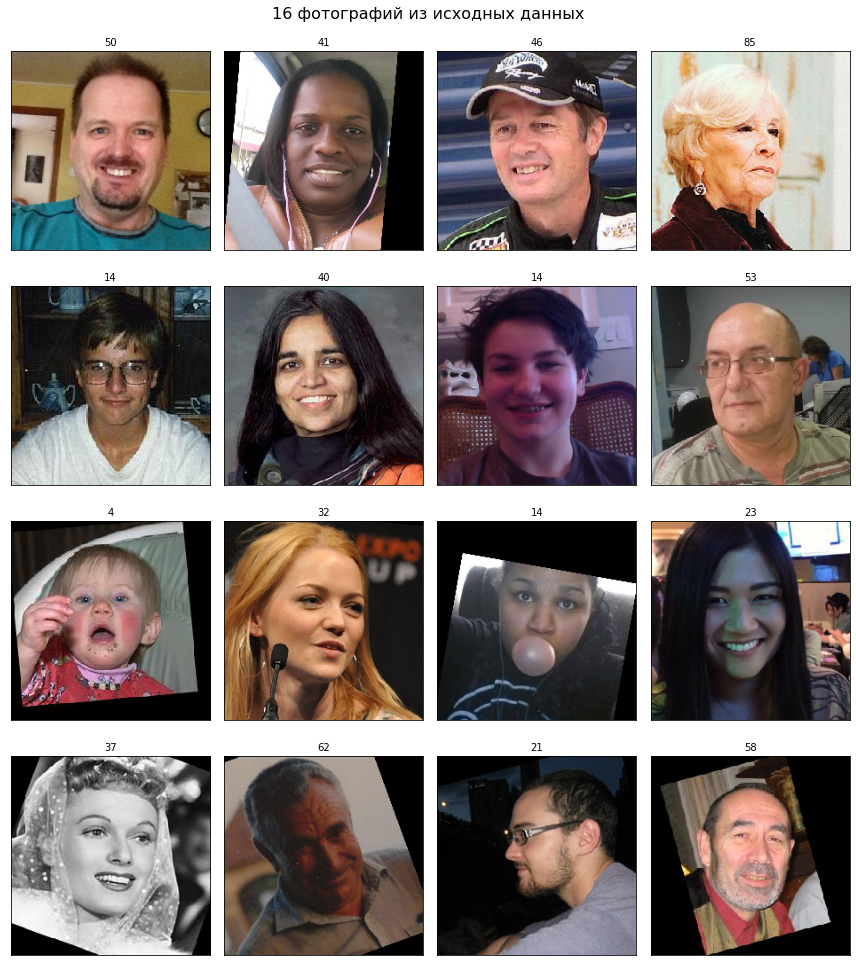

In [5]:
# динамическая загрузка данныхс помощью ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

# создание пар «картинки — метки»
features, target = next(train_gen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(12,14))
fig.suptitle('16 фотографий из исходных данных', fontsize=16)
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(target[i], fontsize=10)

### Вывод

В результате исследования мы выяснили, что размер датасета небольшой - 7591 объект, качество некоторых фотографий среднее - встречаются обрезанные, затемненные либо засветленные фотографии, есть черно-белые фотографии. Общая ориентация фотографий одинаковая - они уже были перевернуты ранее при необходимости. Размер изображений отличается - у перевернутых ранее фотографий есть черная рамка. Поэтому перед обучением модели необходимо будет масштабировать все изображения, преобразовав пиксели в диапазоне [0,255] в диапазон [0,1].

Также мы предполагаем, что в данных не всегда указан точный возраст, есть довольно частные случаи округления возраста (так как на гистограмме распределения возраста есть пики в районе "юбилейных" лет).

Исходя из этого, модель по определению возраста не рекомендуется для оценки возможности продажи алкоголя, но подходит для категоризации покупателей по возрастным группам, анализа покупок в разных категориях и предложения им товаров, которые могут заинтересовать.

## Обучение модели

Код обучения модели:

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       validation_split=0.25,
                                       horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255, 
                                      validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, 
                epochs=10, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

Результат вывода на экран:

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-10-02 12:02:39.617628: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-02 12:02:40.049702: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 52s - loss: 13.9571 - mae: 13.9579 - val_loss: 23.6906 - val_mae: 23.6970
Epoch 2/10
178/178 - 39s - loss: 7.5850 - mae: 7.5858 - val_loss: 14.1579 - val_mae: 14.1167
Epoch 3/10
178/178 - 39s - loss: 6.4926 - mae: 6.4930 - val_loss: 14.4437 - val_mae: 14.3979
Epoch 4/10
178/178 - 37s - loss: 5.6747 - mae: 5.6751 - val_loss: 8.3794 - val_mae: 8.3905
Epoch 5/10
178/178 - 38s - loss: 5.2636 - mae: 5.2642 - val_loss: 6.6804 - val_mae: 6.6864
Epoch 6/10
178/178 - 38s - loss: 4.7796 - mae: 4.7798 - val_loss: 6.2600 - val_mae: 6.2601
Epoch 7/10
178/178 - 38s - loss: 4.4147 - mae: 4.4154 - val_loss: 6.0220 - val_mae: 6.0437
Epoch 8/10
178/178 - 38s - loss: 4.1950 - mae: 4.1957 - val_loss: 6.0596 - val_mae: 6.0824
Epoch 9/10
178/178 - 38s - loss: 4.0032 - mae: 4.0035 - val_loss: 6.2518 - val_mae: 6.2523
Epoch 10/10
178/178 - 38s - loss: 3.8368 - mae: 3.8372 - val_loss: 6.3727 - val_mae: 6.4044
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 6.3727 - mae: 6.4044
Test MAE: 6.4044

```

## Анализ обученной модели

Обученная нами модель показала на тестовой выборке высокий результат - метрика *MAE* = 6.4, успешно преодолев условие из задачи (*MAE* не больше 8). Время обучения достаточно быстрое - около 5 минут. 

Данные были разбиты на обучающую (75%) и тестовую (25%) выборки и загружены с помощью ImageDataGenerator. В тренировочной выборке мы применили к изображениям горизонтальный флип (`horizontal_flip=True`) для увеличения выборки. Так как качество изображений среднее, в обоих выборках мы масштабировали все изображения (`rescale=1/255`), преобразовав пиксели в диапазоне [0,255] в диапазон [0,1] для лучшего результата предсказания модели и уменьшения времени обучения.

В нашей модели мы использовали архитектуру *ResNet50* (количество слоев в сети равно 50). 

При создании модели для улучшения результата предсказания мы задали гиперпараметр инициализации весов `weights='imagenet'` - предварительно обучили сеть на датасете *ImageNet*, затем продолжили обучение на нашей обучающей выборке.

В полносвязном слое *Dense* была применена активация *ReLU*, так как она не меняет положительные прогнозы сети, а все отрицательные — приводит к нулю. 

Так как определение возраста человека - задача регрессии, в качестве функции потерь и метрики качества мы использовали *MAE*.

**Вывод:** Несмотря на высокое значение метрики *MAE* на тестовой выборке, опираясь на результат исследовательского анализа данных в п.1, мы считаем, что данная модель по определению возраста человека может быть успешно применена только для категоризации покупателей по возрастным группам, использование модели для оценки возможности продажи алкоголя не рекомендуется.